28 emnist 115
clustering algorithm failed to terminate in bidirectional step
0.5391142054434708 0.008773736222229211
0.008773736222229211 0.34747489992853176
emnist, (28, 28), number of trivial vectors = 115
method = label based, accs = (0.9527720739219713, 0.6211734693877551)
28.1976665505677 28.0
sym_lbl.gt_swap_score(data)=tensor(0.0710, device='cuda:0', grad_fn=<DivBackward0>)


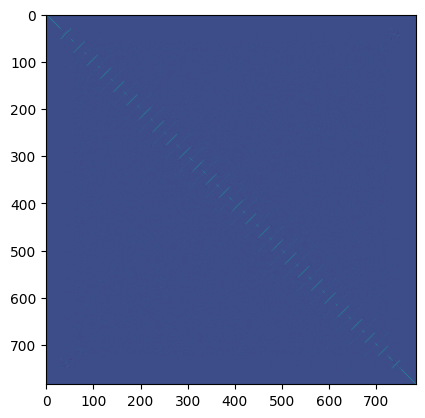

(eigenvalues[0] - eigenvalues[1]) / eigenvalues.min() = 0.3202282111299118 > 0.1
(eigenvalues[0] - eigenvalues[1]) / eigenvalues.min() = 0.11422101035286396 > 0.1
(eigenvalues[0] - eigenvalues[1]) / eigenvalues.min() = 0.1924317252117854 > 0.1
780
779
potential angles = [0.06494215393395257, -0.7204560094634958], np.argmin(cov_penalties)=0
cov_penalties=[2.820664268842252, 539.8222865797628]
[25.48665546 26.44538325]
optimal angle in degrees=3.7209113329043983
[[ 0.997892   -0.06489651]
 [ 0.06489651  0.997892  ]]

778
(eigenvalues[0] - eigenvalues[1]) / eigenvalues.min() = 0.1884799336094948 > 0.1
(eigenvalues[0] - eigenvalues[1]) / eigenvalues.min() = 0.15746065937381704 > 0.1
(eigenvalues[0] - eigenvalues[1]) / eigenvalues.min() = 0.10020436509965992 > 0.1
774
potential angles = [-0.054303747977157445, 0.7310944154202909], np.argmin(cov_penalties)=0
cov_penalties=[0.45242333891785586, 127.91619661682797]
[14.63569774 15.3719878 ]
optimal angle in degrees=-3.111375570833203
[[ 0.9985

ValueError: Fine Tune failure. NaNs in the model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from core import SymmetryFinder, SymmetryFinderLabel
from numpy.random import default_rng
import torchvision
import logging
import torchvision.transforms.functional as funct
import torchvision.transforms as transforms
from sklearn.utils import shuffle
import itertools
import pandas as pd
import random
import dill
from pathlib import Path

DATA_PATH = Path("..") / "data"
logging.basicConfig(filename="../logs/semisynthetic_label_based.log", level=logging.WARNING)


def ground_truth_loss(mat1, mat2):
    return np.sqrt(np.mean((mat1 - mat2) ** 2))


def horiz_flip_gt_accuracy(model, dim=(28, 28), angle_threshold=30):
    # flip = transforms.RandomHorizontalFlip(p=1.)
    # eigenvector1 = model.eigenvectors_.reshape(dim[0], dim[1], -1)

    eigenvectors = model.eigenvectors_.T.reshape(-1, dim[0], dim[1])
    diff = np.array(
        [eigenvectors[i].reshape(-1, dim[0] * dim[1]) @ eigenvectors[i, :, ::-1].reshape(-1, dim[0] * dim[1]).T for i in
         range(eigenvectors.shape[0])])
    diff = diff.reshape(-1)
    diff = np.arccos(diff) * 180 / np.pi
    diff[diff > 90 + angle_threshold] = -1
    diff[(90 + angle_threshold >= diff) & (diff >= 90 - angle_threshold)] = 0
    diff[(0 < diff) & (diff < 90 - angle_threshold)] = 1
    return np.sum(diff == model.trans_eigenvalues_) / sum((diff != 0)), sum((diff != 0)) / len(diff)


if __name__ == '__main__':
    # num_samples = NUM_SAMPLES
    space_dims = [28]
    methods = []
    datasets = ['emnist'] # 'mnist'
    # num_samples_list = [2_000, 10_000, 50_000, 250_000]

    # print(df_error)
    df_cov_acc = pd.DataFrame(columns=space_dims, index=datasets, dtype=float)
    for dataset in datasets:
        df_acc = pd.DataFrame(columns=methods, index=space_dims, dtype=float)
        save_file = DATA_PATH / f"{dataset}_acc_lbl.csv"
        for space_dim in space_dims:
            torch.manual_seed(42)
            rng = default_rng(42)

            trans_mat = np.eye(space_dim * space_dim).reshape(space_dim, space_dim, space_dim, space_dim)
            trans_mat = trans_mat[:, :, :, ::-1]
            trans_mat = trans_mat.reshape(space_dim * space_dim, space_dim * space_dim)

            dim = (space_dim, space_dim)
            strt_msg = f"Starting Experiment: methods = {', '.join(methods)}, space_dim = {space_dim}"
            logging.info(strt_msg)
            if dataset == 'emnist':
                if space_dims == 28:
                    transform = transforms.Compose(
                        [
                            lambda x: funct.rotate(x, angle=-90),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
                else:
                    transform = transforms.Compose(
                        [
                            lambda x: funct.rotate(x, angle=-90),
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(dim),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
            else:
                if space_dims == 28:
                    transform = transforms.Compose(
                        [
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
                else:
                    transform = transforms.Compose(
                        [
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(dim),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
            if dataset == 'emnist':
                trainset = torchvision.datasets.EMNIST(root=str(DATA_PATH), train=True,
                                                       download=True, transform=transform,
                                                       split="digits"
                                                       )
            else:
                trainset = torchvision.datasets.MNIST(root=str(DATA_PATH), train=True,
                                                      download=True, transform=transform,
                                                      )



            data = np.array([x for i, (x, label) in enumerate(trainset)])
            labels = np.array([label for i, (x, label) in enumerate(trainset)])
            data = data / np.std(data)
            data, labels = shuffle(data, labels)

            cov = np.cov(data, rowvar=False)
            eigen = np.linalg.eig(cov)
            cov_eigenvalues = np.real(eigen[0])
            eigenvectors = np.real(eigen[1])
            mu = np.mean(data, axis=0)
            sol = np.linalg.solve(eigenvectors, mu)
            num_trivial_vectors = np.sum((sol < SymmetryFinder.ignore_threshold) & \
                                         (cov_eigenvalues < SymmetryFinder.ignore_threshold))
            print(space_dim, dataset, num_trivial_vectors)
            swaps = int((dim[0] * dim[1] - num_trivial_vectors) // 2)
            # print(type(swaps))
            # for i, method in enumerate(methods):
            #     sym = SymmetryFinder(fit_method=method, select_method=swaps)
            #     sym.fit(data, cov=cov)
            #     accs = horiz_flip_gt_accuracy(sym, dim=dim)
            #     msg = f"method = {method}, accs = {accs}"
            #     logging.info(msg)
            #     print(msg)
            #     df_acc.loc[space_dim, method] = accs[0]
            #     df_cov_acc.loc[dataset, space_dim] = accs[1]
            sym_lbl = SymmetryFinderLabel(select_method=swaps, bidirectional=True)
            sym_lbl.fit(data, labels)
            print(f"{dataset}, {dim}, number of trivial vectors = {sum(sym_lbl.trivial_vectors_ == True)}")
            accs = horiz_flip_gt_accuracy(sym_lbl, dim=dim)
            msg = f"method = label based, accs = {accs}"
            logging.info(msg)
            print(msg)
            print(np.linalg.norm(sym_lbl.trans_ - trans_mat), np.linalg.norm(trans_mat))
            print(f"{sym_lbl.gt_swap_score(data)=}")
            # sym_lbl.fine_tune(data, lr=0.0001, bandwidth=50, epochs=60, negativity_penalty=True)
            plt.imshow(sym_lbl.trans_)
            plt.show()


            sym_lbl_healed = SymmetryFinderLabel(select_method=swaps, bidirectional=True, heal_eigenvectors=True)
            sym_lbl_healed.fit(data, labels)
            accs = horiz_flip_gt_accuracy(sym_lbl_healed, dim=dim)
            msg = f"method = eigenvector healing, accs = {accs}"
            logging.info(msg)
            print(msg)
            print(np.linalg.norm(sym_lbl_healed.trans_ - trans_mat), np.linalg.norm(trans_mat))
            print(f"{sym_lbl_healed.gt_swap_score(data)=}")
            plt.imshow(sym_lbl_healed.trans_)
            plt.show()

            # plt.imshow(sym_lbl.ft_trans_)
            # plt.show()
            # plt.imshow(trans_mat)
            # plt.show()
            # df_acc.loc[space_dim, method] = accs[0]
            # df_cov_acc.loc[dataset, space_dim] = accs[1]
    #     df_acc.to_csv(save_file)
    # df_cov_acc.to_csv(DATA_PATH / "cov_acc_lbl.csv")

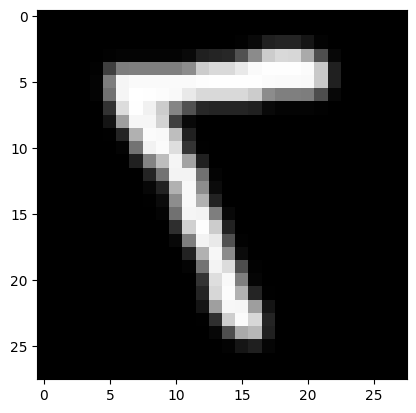

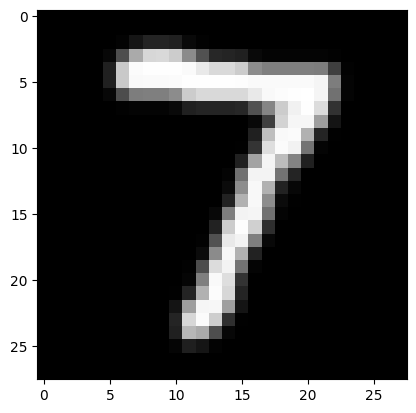

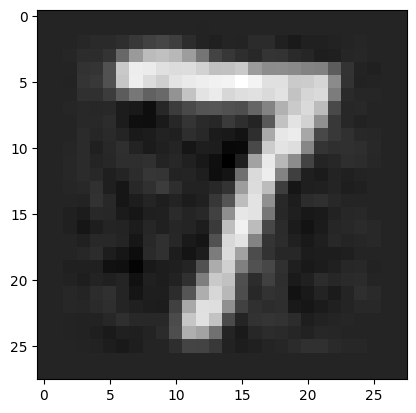

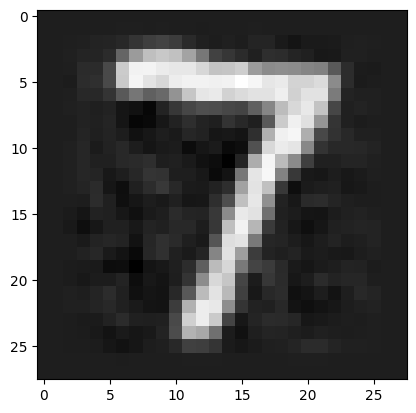

In [13]:
index = 5
dim=28
plt.imshow(data[index].reshape(dim, dim), cmap='gray')
plt.show()
plt.imshow(data[index].reshape(dim, dim)[:,::-1], cmap='gray')
plt.show()
plt.imshow(sym_lbl_healed.predict(data[index]).reshape(dim, dim), cmap='gray')
plt.show()